In [157]:
# !wget -q http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 2>&1 > /dev/null
# !tar xvzf ta-lib-0.4.0-src.tar.gz 2>&1 > /dev/null

# import os

# os.chdir('ta-lib') # Can't use !cd in co-lab

# !./configure --prefix=/usr 2>&1 > /dev/null
# !make 2>&1 > /dev/null
# !make install 2>&1 > /dev/null

# os.chdir('../')

# !pip install TA-Lib 2>&1 > /dev/null

# Run this commands to run the project on Google Colab


In [158]:
# !pip install yfinance
# YFinance needs to be installed as we use Yahoo Finance to scrape data
# from the yahoo finance website and process it further.

In [159]:
from pandas.core.frame import DataFrame
import yfinance as yf
import numpy as np
import talib as ta
import pandas as pd

In [160]:
"""
Parameters
----------
df -> Dataframe of stock's historical data
indicator -> mathematical formula to make an indicator on
	Supported indicators:
		rsi -> Relative Strength Indicator
		macd -> Moving Average Convergence Divergence
		ema -> Exponential Moving Average
		volume -> It's not actually an indicator but we are using it to analyse
		price volume data by correlating price movements with volume.
entry_type -> The view of underlying stock.
	long -> We take long entry for bullishness
	short -> We take short entry for bearishness
"""
def get_score(df: DataFrame, indicator: str, entry_type='long'):
	indicator = indicator.upper()
 
	if indicator == 'RSI' and entry_type == 'long':
		"""
		General Strategy with RSI:
			If RSI Value is >= 70:
				It is considered that the stock is overpriced as
				the stock is overbought in the last few trading sessions.
				
				Increasing RSI is generally considered a negative sign,
				and the stock is expected to be bearish.
			If RSI Value is <= 30:
				It is considered that the stock is underpriced as
				the stock is oversold in the last few trading sessions.

				Decreasing RSI is generally considered as a positive sign,
				and the stock is expected to be bullish in upcoming trading sessions.

		Our strategy with RSI:
			If RSI Value in range of 60-70
				We consider this the best range of RSI as if the stock has
				RSI value of >=60 and <= 70. It is not overbought but it actually
				deserves to be a performing stock.

				We expect the stock to perform more in upcoming trading sessions.

			If RSI Value in range of 70-80
				We consider this the next best range of RSI. If the stock is in 
				ragne of this we can expect bullishness but now the upmove is
				considered to be weak as the move may have came to an end as 
				RSI is already this much high.
			
			If RSI Value in range of >= 80
			 	We consider this as a weakening score and a potential threat, 
				as the stock might be actually overperforming. 

				This is just like a typical overbought zone.
			
			If RSI Value in range 50-60
				We consider this as a moderate range, and the stock might
				start performing from here. So we return the score with value of 2.

			If any given condition is not matched we simply return the score value of 0.
		"""
		try:
			rsiValue = df.rsi.head(1).values[0]
			if rsiValue in range(60,70):
				return 5
			elif rsiValue in range(70,80):
				return 4
			elif rsiValue >= 80:
				return 3
			elif rsiValue in range(50,60):
				return 2
			else:
				return 0
		except IndexError:
			return 0
	"""
		General Strategy with MACD:
			In MACD there are two components which are calculated.
			MACD Signal and MACD.
			If value of MACD is greaten than MACD Signal, 
				it is considered a bullish crossover and the stock might
				start performing from here.
			If value of MACD is less than MACD Signal,
				it is considered a bearish crossover and the stock might
				start falling from here.

		Our Strategy with MACD:
			We go along with the general strategy but with some modifications.
			Instead of simply checking the condition of MACD > Macd Signal, 
			we check when the crossover happened.

			The nearer the crossover with today's date the more strength the
			buy signal has.
	"""
	if indicator == 'MACD' and entry_type == 'long':
		macd = df.macd_crossover
		try:
			date = macd.iloc[list(np.where(df["macd_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'EMA' and entry_type == 'long':
		try:
			date = df.ema_crossover.iloc[list(np.where(df["ema_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'VOLUME' and entry_type == 'long':
		try:
			date = df.volume_buy.iloc[list(np.where(df["volume_buy"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	return None

In [161]:
# Downloading the data of infosys with yfinance
data = pd.read_csv('INFY.csv')
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-21,963.049988,963.450012,946.549988,948.799988,928.694214,6513773
2020-08-24,947.000000,952.000000,939.200012,947.400024,927.323975,5798574
2020-08-25,947.500000,948.650024,933.599976,938.099976,918.220947,6233918
2020-08-26,941.250000,954.250000,938.400024,950.799988,930.651855,5153601
2020-08-27,960.000000,960.950012,945.200012,947.049988,926.981323,6154280


In [162]:
span = 5

In [163]:
data = data.tail(span+5)

In [164]:
data['5EMA'] = pd.Series.ewm(data['Close'], span=5).mean()

data['26EMA'] = pd.Series.ewm(data['Close'], span=26).mean()

data['rsi'] = ta.RSI(data['Close'].values, timeperiod=14)

data['macd'], data['macdSignal'], data['macdHist'] = ta.MACD(data.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)

data['macd_crossover'] = np.where(((data.macd > data.macdSignal) & (data.macd.shift(1) < data.macdSignal.shift(1))), 1, 0)
data['macd_crossunder'] = np.where(((data.macd < data.macdSignal) & (data.macd.shift(1) > data.macdSignal.shift(1))), 1, 0)
data['ema_crossover'] = np.where(((data['5EMA'].shift(1) <= data['26EMA'].shift(1)) & (data['5EMA'] > data['26EMA'] )), 1, 0)
data['ema_crossunder'] = np.where(((data['5EMA'].shift(1) >= data['26EMA'].shift(1)) & (data['5EMA'] < data['26EMA'] )), 1, 0)

data['rsi_buy'] = np.where(data.rsi > 60, 1, 0)
data['rsi_sell'] = np.where(data.rsi < 40, 1, 0)

data['volume_buy'] = np.where((data.Volume > data.Volume.ewm(span=5).mean()) & (data.Close > data.Close.shift(1)), 1, 0)
data['volume_sell'] = np.where((data.Volume > data.Volume.ewm(span=5).mean()) & (data.Close < data.Close.shift(1)), 1, 0)

last_week_data = data.tail(5).sort_values(by='Date', ascending=False)
rsiScore = get_score(last_week_data, indicator='rsi')
macdScore = get_score(last_week_data, indicator='macd')
emaScore = get_score(last_week_data, indicator='ema')
volumeScore = get_score(last_week_data, indicator='volume')
totalScore = rsiScore + macdScore + emaScore + volumeScore

In [165]:
totalScoreL = [0,0,0,0,0]
for i in range(len(data.index.values)-5):
	df = data[i:i+5]
	rsiScore = get_score(df, indicator='rsi')
	macdScore = get_score(df, indicator='macd')
	emaScore = get_score(df, indicator='ema')
	volumeScore = get_score(df, indicator='volume')
	totalScore = rsiScore + macdScore + emaScore + volumeScore
	totalScoreL.append(totalScore)
len(totalScoreL)

10

In [166]:
print(len(data))
data

10


,Open,High,Low,Close,Adj Close,Volume,5EMA,26EMA,rsi,macd,macdSignal,macdHist,macd_crossover,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell
Date,,,,,,,,,,,,,,,,,,,,
2021-08-06,1657.000000,1660.650024,1644.000000,1650.199951,1650.199951,3754855,1650.199951,1650.199951,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2021-08-09,1661.000000,1667.449951,1646.400024,1663.300049,1663.300049,5018477,1658.060010,1657.001925,NaN,NaN,NaN,NaN,0,0,1,0,0,0,1,0
2021-08-10,1668.000000,1680.000000,1661.050049,1677.250000,1677.250000,6846517,1667.150005,1664.276862,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
2021-08-11,1674.800049,1684.000000,1668.000000,1677.550049,1677.550049,4899639,1671.470023,1667.987465,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2021-08-12,1679.150024,1696.500000,1674.000000,1689.599976,1689.599976,5659579,1678.429863,1672.999495,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,1712.199951,5612790,1690.769910,1680.851034,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,1704.400024,4564109,1695.595725,1685.039100,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,1741.650024,9510390,1711.570468,1694.160522,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
2021-08-18,1729.000000,1755.500000,1727.000000,1733.449951,1733.449951,6686090,1719.058407,1699.984078,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1


In [167]:
data = data.iloc[-5:,:]

In [168]:
data['totalScore'] = totalScoreL[-5:]
data['totalScoreEma'] = data.totalScore.ewm(span=span).mean()

C:\Users\HP\AppData\Local\Temp/ipykernel_7604/3530090897.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['totalScore'] = totalScoreL[-5:]
C:\Users\HP\AppData\Local\Temp/ipykernel_7604/3530090897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['totalScoreEma'] = data.totalScore.ewm(span=span).mean()


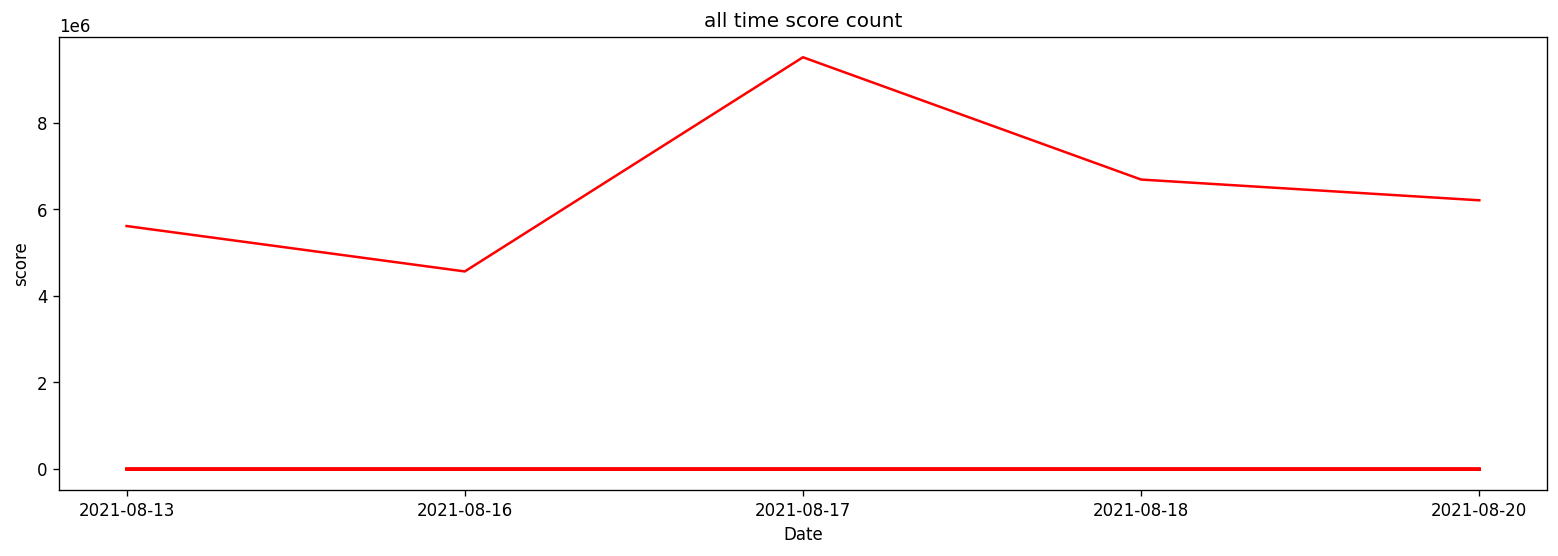

In [169]:
import matplotlib.pyplot as plt
def draw_ts_plot(timeseries, xlabel ='Date', ylabel ='totalScore', title ="", dpi=120):
    plt.figure(figsize=(16,5),dpi=dpi)
    plt.plot(timeseries, color='red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

draw_ts_plot(data, xlabel="Date", ylabel = "score", title="all time score count")

In [170]:
len(data)

5

In [171]:
data

,Open,High,Low,Close,Adj Close,Volume,5EMA,26EMA,rsi,macd,...,macd_crossover,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell,totalScore,totalScoreEma
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,1712.199951,5612790,1690.769910,1680.851034,NaN,NaN,...,0,0,0,0,0,0,1,0,8,8.000000
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,1704.400024,4564109,1695.595725,1685.039100,NaN,NaN,...,0,0,0,0,0,0,0,0,10,9.200000
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,1741.650024,9510390,1711.570468,1694.160522,NaN,NaN,...,0,0,0,0,0,0,1,0,5,7.210526
2021-08-18,1729.000000,1755.500000,1727.000000,1733.449951,1733.449951,6686090,1719.058407,1699.984078,NaN,NaN,...,0,0,0,0,0,0,0,1,4,5.876923
2021-08-20,1716.099976,1745.000000,1716.099976,1732.949951,1732.949951,6206972,1723.770639,1704.533048,NaN,NaN,...,0,0,0,0,0,0,0,0,5,5.540284


In [172]:
data['dates'] = data.index.values
data['dates'] = data['dates'].apply(lambda x: x.split('-')[2])

C:\Users\HP\AppData\Local\Temp/ipykernel_7604/1350104779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dates'] = data.index.values
C:\Users\HP\AppData\Local\Temp/ipykernel_7604/1350104779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dates'] = data['dates'].apply(lambda x: x.split('-')[2])


In [173]:
totalScoreX = data.iloc[:,-2:-1]

In [174]:
datesY = data["dates"]
datesY = datesY.astype(int)

In [175]:
data

,Open,High,Low,Close,Adj Close,Volume,5EMA,26EMA,rsi,macd,...,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell,totalScore,totalScoreEma,dates
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,1712.199951,5612790,1690.769910,1680.851034,NaN,NaN,...,0,0,0,0,0,1,0,8,8.000000,13
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,1704.400024,4564109,1695.595725,1685.039100,NaN,NaN,...,0,0,0,0,0,0,0,10,9.200000,16
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,1741.650024,9510390,1711.570468,1694.160522,NaN,NaN,...,0,0,0,0,0,1,0,5,7.210526,17
2021-08-18,1729.000000,1755.500000,1727.000000,1733.449951,1733.449951,6686090,1719.058407,1699.984078,NaN,NaN,...,0,0,0,0,0,0,1,4,5.876923,18
2021-08-20,1716.099976,1745.000000,1716.099976,1732.949951,1732.949951,6206972,1723.770639,1704.533048,NaN,NaN,...,0,0,0,0,0,0,0,5,5.540284,20


In [176]:
len(totalScoreX),len(datesY)

(5, 5)

In [177]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(datesY).reshape(-1, 1), totalScoreX)

LinearRegression()

In [178]:
data.tail(10)

,Open,High,Low,Close,Adj Close,Volume,5EMA,26EMA,rsi,macd,...,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell,totalScore,totalScoreEma,dates
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-13,1697.000000,1722.500000,1691.300049,1712.199951,1712.199951,5612790,1690.769910,1680.851034,NaN,NaN,...,0,0,0,0,0,1,0,8,8.000000,13
2021-08-16,1707.699951,1719.949951,1690.099976,1704.400024,1704.400024,4564109,1695.595725,1685.039100,NaN,NaN,...,0,0,0,0,0,0,0,10,9.200000,16
2021-08-17,1703.900024,1748.900024,1686.550049,1741.650024,1741.650024,9510390,1711.570468,1694.160522,NaN,NaN,...,0,0,0,0,0,1,0,5,7.210526,17
2021-08-18,1729.000000,1755.500000,1727.000000,1733.449951,1733.449951,6686090,1719.058407,1699.984078,NaN,NaN,...,0,0,0,0,0,0,1,4,5.876923,18
2021-08-20,1716.099976,1745.000000,1716.099976,1732.949951,1732.949951,6206972,1723.770639,1704.533048,NaN,NaN,...,0,0,0,0,0,0,0,5,5.540284,20


C:\Users\HP\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


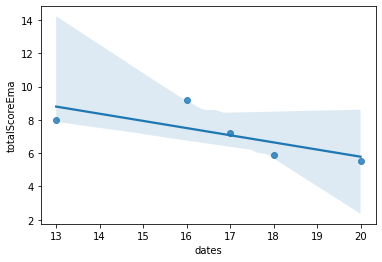

In [179]:
import seaborn as sns
sns.regplot(datesY, totalScoreX)
plt.show()

In [151]:
data

,Open,High,Low,Close,Volume,5EMA,26EMA,rsi,macd,macdSignal,...,macd_crossunder,ema_crossover,ema_crossunder,rsi_buy,rsi_sell,volume_buy,volume_sell,totalScore,totalScoreEma,dates
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-09,1759.000000,1769.400024,1742.000000,1763.449951,2082171,1739.864993,1729.654535,56.432585,2.929650,1.641616,...,0,0,0,0,0,0,0,1,1.000000,09
2021-12-10,1760.000000,1763.750000,1746.000000,1759.250000,1823469,1746.326662,1731.847373,55.554164,4.846515,2.282596,...,0,0,0,0,0,0,0,3,2.100000,10
2021-12-13,1767.050049,1771.349976,1738.800049,1744.650024,4040584,1745.767783,1732.795951,52.495132,5.128431,2.851763,...,0,0,0,0,0,0,1,5,3.265781,13
2021-12-14,1730.900024,1763.000000,1710.349976,1752.150024,4768144,1747.895197,1734.229912,53.899456,5.889152,3.459240,...,0,0,0,0,0,1,0,7,4.496040,14
2021-12-15,1745.000000,1747.949951,1721.199951,1734.199951,3053149,1743.330115,1734.227692,50.083417,4.986131,3.764619,...,0,0,0,0,0,0,0,10,6.076077,15


In [181]:
yhat = model.predict([[22]]) #predict score for next day
yhat

array([[4.92708702]])

In [182]:
data.iloc[:,-2:]

,totalScoreEma,dates
Date,,
2021-08-13,8.000000,13
2021-08-16,9.200000,16
2021-08-17,7.210526,17
2021-08-18,5.876923,18
2021-08-20,5.540284,20


In [183]:
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
# x =Open	High	Low	Close	Volume
# y = 5EMA	26EMA	rsi	macd	macdSignal	macdHist
regressor.fit(np.asarray(data['totalScoreEma']).reshape(-1, 1),data['Close'])

RandomForestRegressor(random_state=0)

C:\Users\HP\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


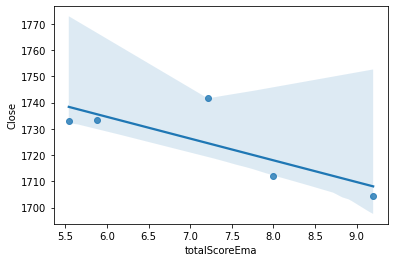

In [187]:
import seaborn as sns
sns.regplot(data['totalScoreEma'], data['Close'])
plt.show()

In [186]:
regressor.predict(yhat)#predict close

array([1733.26895264])

# Results
Our model first predcited the closing price of Infosys as 1735 and the actual close price of 23rd August, 2021 was 1738.75